In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weatherww2/Summary of Weather.csv
/kaggle/input/weatherww2/Weather Station Locations.csv
/kaggle/input/world-war-ii/operations.csv


# Exploring Data

In [2]:
# loading required libraries
!pip install chart_studio
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from chart_studio import plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)

from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.3 MB/s eta 0:00:00


### Load the data

In [3]:
# bombing data
aerial_df = pd.read_csv('/kaggle/input/world-war-ii/operations.csv')

aerial_df.head()

Mission ID Mission Date Theater of Operations Country Air Force  \
0           1    8/15/1943                   MTO     USA     12 AF   
1           2    8/15/1943                   PTO     USA      5 AF   
2           3    8/15/1943                   MTO     USA     12 AF   
3           4    8/15/1943                   MTO     USA     12 AF   
4           5    8/15/1943                   PTO     USA      5 AF   

         Unit ID Aircraft Series Callsign Mission Type          Takeoff Base  \
0  27 FBG/86 FBG             A36      NaN          NaN  PONTE OLIVO AIRFIELD   
1         400 BS             B24      NaN            1                   NaN   
2  27 FBG/86 FBG             A36      NaN          NaN  PONTE OLIVO AIRFIELD   
3  27 FBG/86 FBG             A36      NaN          NaN  PONTE OLIVO AIRFIELD   
4         321 BS             B24      NaN            1                   NaN   

   ... Incendiary Devices Weight (Tons) Fragmentation Devices  \
0  ...                              NaN                   NaN   
1  ...                              NaN                   NaN   
2  ...                              NaN                   NaN   
3  ...                              NaN                   NaN   
4  ...                              NaN                   NaN   

   Fragmentation Devices Type Fragmentation Devices Weight (Pounds)  \
0                         NaN                                   NaN   
1                         NaN                                   NaN   
2                         NaN                                   NaN   
3                         NaN                                   NaN   
4                         NaN                                   NaN   

  Fragmentation Devices Weight (Tons) Total Weight (Pounds)  \
0                                 NaN                   NaN   
1                                 NaN                   NaN   
2                                 NaN                   NaN   
3                                 NaN                   NaN   
4                                 NaN                   NaN   

  Total Weight (Tons) Time Over Target Bomb Damage Assessment  Source ID  
0                10.0              NaN                    NaN        NaN  
1                20.0              NaN                    NaN     9366.0  
2                 9.0              NaN                    NaN        NaN  
3                 7.5              NaN                    NaN        NaN  
4                 8.0              NaN                    NaN    22585.0  

[5 rows x 46 columns]

In [4]:
# weather data including country location latitude, longitude
weather_station_location_df = pd.read_csv("/kaggle/input/weatherww2/Weather Station Locations.csv")

weather_station_location_df.head()

WBAN            NAME STATE/COUNTRY ID    LAT     LON  ELEV   Latitude  \
0  33013          AIN EL               AL  3623N  00637E   611  36.383333   
1  33031        LA SENIA               AL  3537N  00037E    88  35.616667   
2  33023  MAISON BLANCHE               AL  3643N  00314E    23  36.716667   
3  33044        TELERGMA               AL  3607N  00621E   754  36.116667   
4  12001         TINDOUF               AL  2741N  00809W   443  27.683333   

   Longitude  
0   6.650000  
1   0.583333  
2   3.216667  
3   6.416667  
4  -8.083333

In [5]:
# second weather data that includes min, max and mean temperatures
weather_df = pd.read_csv("/kaggle/input/weatherww2/Summary of Weather.csv")

weather_df.head()

STA      Date Precip  WindGustSpd    MaxTemp    MinTemp   MeanTemp  \
0  10001  1942-7-1  1.016          NaN  25.555556  22.222222  23.888889   
1  10001  1942-7-2      0          NaN  28.888889  21.666667  25.555556   
2  10001  1942-7-3   2.54          NaN  26.111111  22.222222  24.444444   
3  10001  1942-7-4   2.54          NaN  26.666667  22.222222  24.444444   
4  10001  1942-7-5      0          NaN  26.666667  21.666667  24.444444   

  Snowfall PoorWeather  YR  ...  FB  FTI ITH  PGT  TSHDSBRSGF  SD3  RHX  RHN  \
0      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
1      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
2      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
3      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
4      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   

  RVG  WTE  
0 NaN  NaN  
1 NaN  NaN  
2 NaN  NaN  
3 NaN  NaN  
4 NaN  NaN  

[5 rows x 31 columns]

### Data Cleaning

In [6]:
# drop countries that are NaN
aerial_df = aerial_df[pd.isna(aerial_df.Country)==False]

# drop if target longitude is NaN
aerial_df = aerial_df[pd.isna(aerial_df['Target Longitude']) == False]

# Drop if takeoff longitude is NaN
aerial_df = aerial_df[pd.isna(aerial_df['Takeoff Longitude']) == False]

# drop unused features
drop_list = ['Mission ID', 'Unit ID', 'Target ID', 'Altitude (Hundreds of Feet)', 
             'Airborne Aircraft', 'Attacking Aircraft', 'Bombing Aircraft', 'Aircraft Returned',
            'Aircraft Failed', 'Aircraft Damaged', 'Aircraft Lost', 'High Explosives', 'High Explosives Type',
             'Mission Type', 'High Explosives Weight (Pounds)', 'High Explosives Weight (Tons)', 'Incendiary Devices',
             'Incendiary Devices Type', 'Incendiary Devices Weight (Pounds)', 'Incendiary Devices Weight (Tons)',
             'Fragmentation Devices', 'Fragmentation Devices Type', 'Fragmentation Devices Weight (Pounds)', 
             'Fragmentation Devices Weight (Tons)', 'Total Weight (Pounds)', 'Total Weight (Tons)', 'Time Over Target',
             'Bomb Damage Assessment', 'Source ID'
             
            ]

aerial_df.drop(drop_list, axis = 1, inplace = True)
aerial_df = aerial_df[aerial_df.iloc[:, 8] != "4248"]
aerial_df = aerial_df[aerial_df.iloc[:, 9] != 1355]

aerial_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2555 entries, 0 to 178080
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Mission Date           2555 non-null   object 
 1   Theater of Operations  2555 non-null   object 
 2   Country                2555 non-null   object 
 3   Air Force              2505 non-null   object 
 4   Aircraft Series        2528 non-null   object 
 5   Callsign               10 non-null     object 
 6   Takeoff Base           2555 non-null   object 
 7   Takeoff Location       2555 non-null   object 
 8   Takeoff Latitude       2555 non-null   object 
 9   Takeoff Longitude      2555 non-null   float64
 10  Target Country         2499 non-null   object 
 11  Target City            2552 non-null   object 
 12  Target Type            602 non-null    object 
 13  Target Industry        81 non-null     object 
 14  Target Priority        230 non-null    object 
 15  Target 

In [7]:
weather_station_loaction_df = weather_station_location_df.loc[:,["WBAN", "NAME", "STATE/COUNTRY ID", "Latitude", "Longitude"] ]
weather_station_location_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WBAN              161 non-null    int64  
 1   NAME              161 non-null    object 
 2   STATE/COUNTRY ID  161 non-null    object 
 3   LAT               161 non-null    object 
 4   LON               161 non-null    object 
 5   ELEV              161 non-null    int64  
 6   Latitude          161 non-null    float64
 7   Longitude         161 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 10.2+ KB


In [8]:
weather_df = weather_df.loc[:,["STA", "Date", "MeanTemp"]]
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   STA       119040 non-null  int64  
 1   Date      119040 non-null  object 
 2   MeanTemp  119040 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ MB


## Data Visualization

Country
USA              1895
GREAT BRITAIN     544
NEW ZEALAND       102
SOUTH AFRICA       14
Name: count, dtype: int64


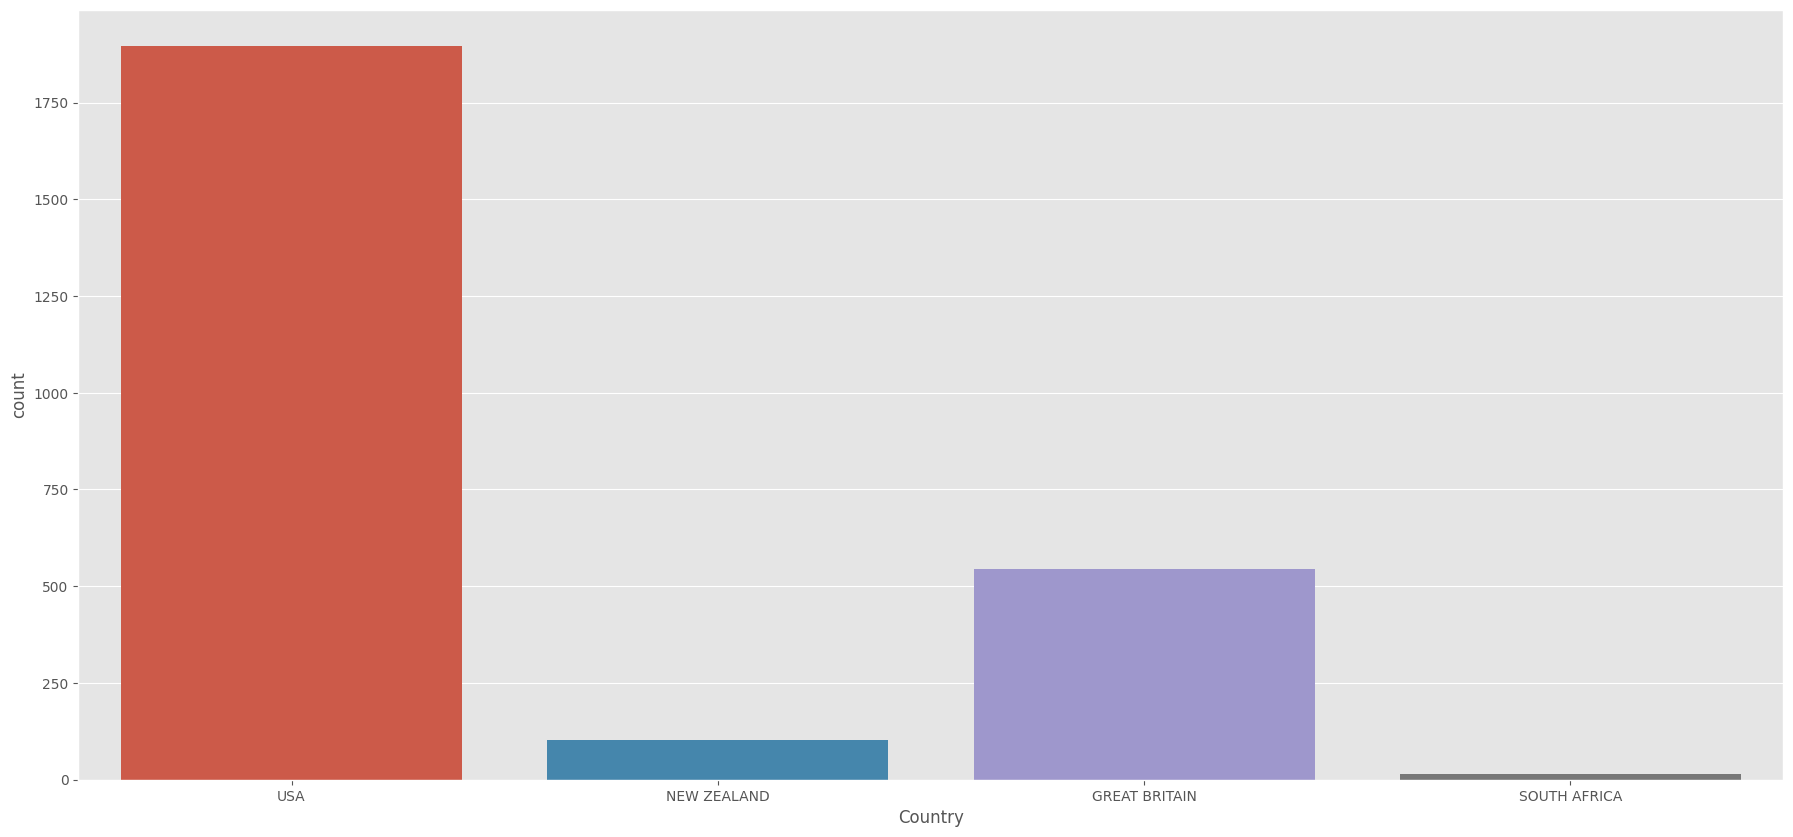

In [9]:
# country
print(aerial_df['Country'].value_counts())
plt.figure(figsize=(22, 10))
sns.countplot(x = 'Country', data = aerial_df)
plt.show()

Target Country
ITALY      1104
BURMA       335
LIBYA       272
TUNISIA     113
GREECE       87
EGYPT        80
JAPAN        71
CHINA        52
SICILY       46
GERMANY      41
Name: count, dtype: int64


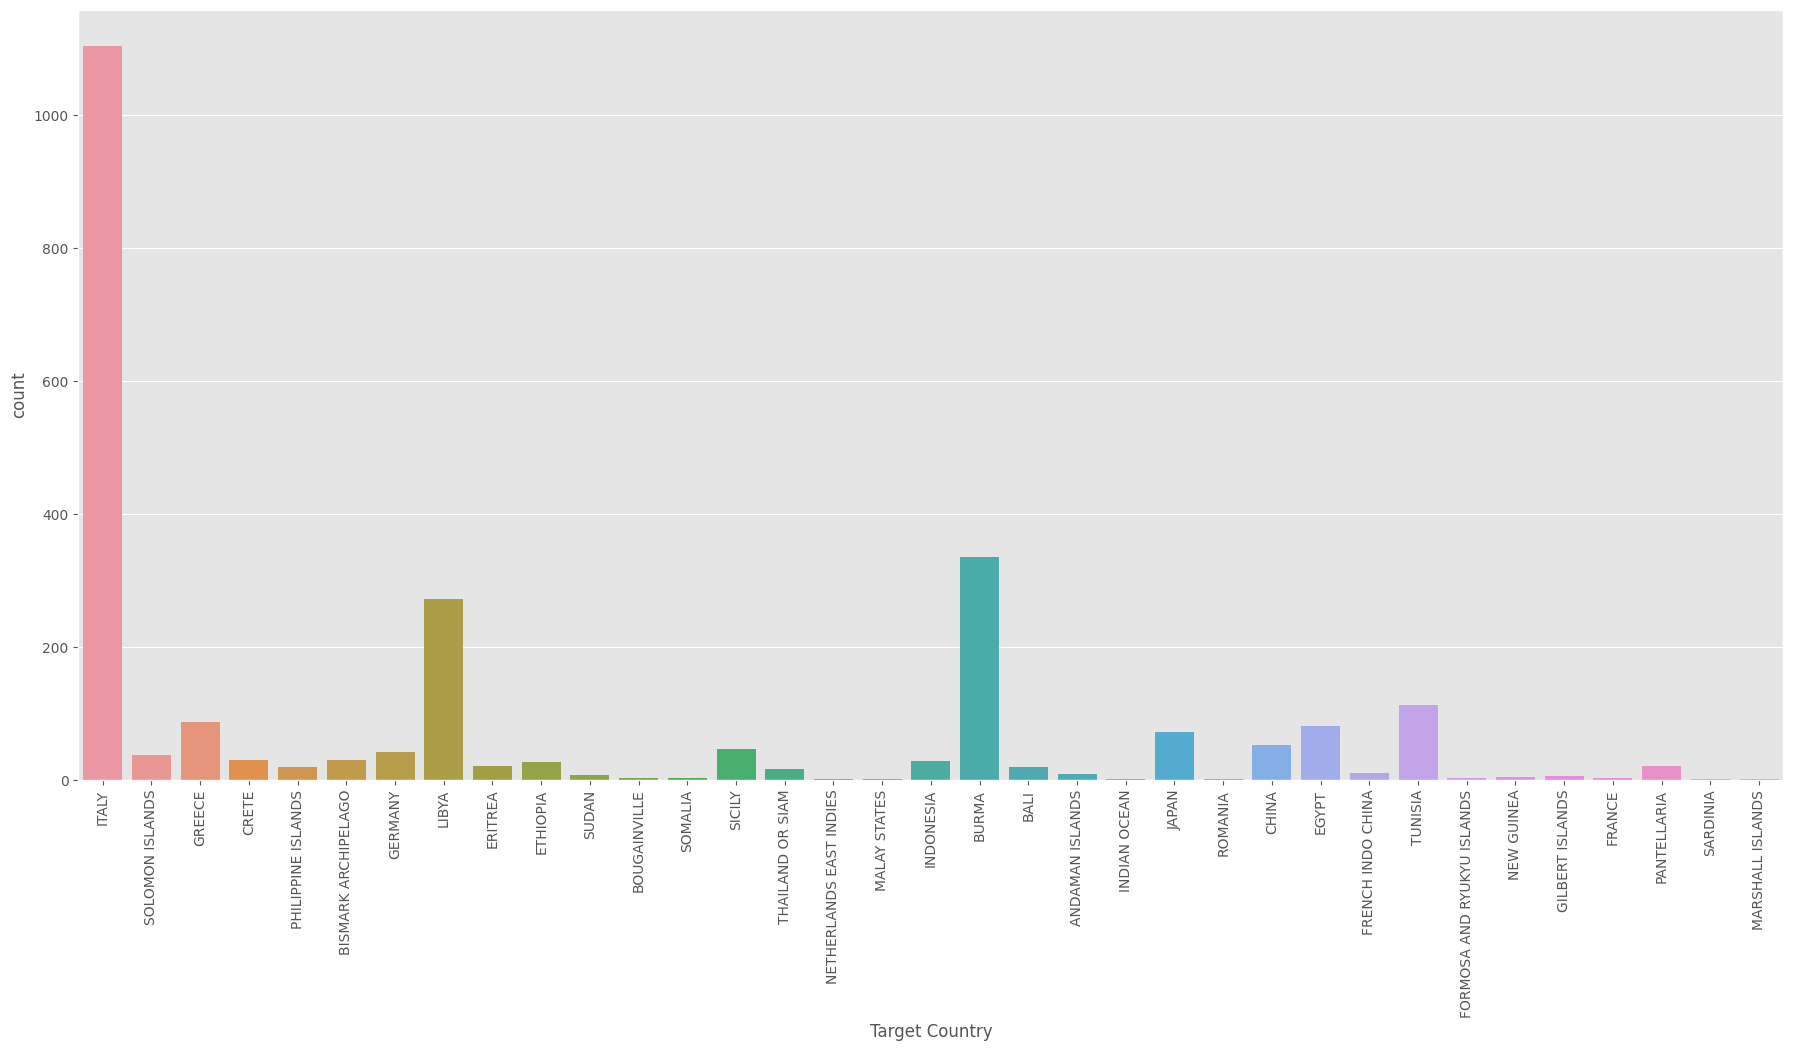

In [10]:
# Top target countries
print(aerial_df['Target Country'].value_counts()[:10])
plt.figure(figsize=(22, 10))
sns.countplot(data = aerial_df, x = 'Target Country')
plt.xticks(rotation = 90)
plt.show()

In [11]:
# Aircraft Series
data = aerial_df['Aircraft Series'].value_counts()
print(data[:10])
data = [go.Bar(
    x = data[:10].index,
    y = data[:10].values,
    hoverinfo = 'text',
    marker = dict(color = 'rgba(177, 14, 22, 0.5)',
                 line = dict(color = 'rgb(0, 0, 0)',
                            width = 1.5
                            )
                 )
)]

layout = dict(title = 'Aircraft Series')
fig = go.Figure(data =  data, layout = layout)
iplot(fig)

Aircraft Series
A36             990
B25             416
B24             337
BLEN            180
LIB             145
WELL            129
B17             119
PV-1 VENTURA     70
WHIT             32
HALI             18
Name: count, dtype: int64


In [12]:
# Attack
aerial_df['color'] = ""
aerial_df.color[aerial_df.Country == 'USA'] = 'rgb(0, 116, 217)'
aerial_df.color[aerial_df.Country == 'GREAT BRITAIN'] = 'rgb(255, 65, 54)'
aerial_df.color[aerial_df.Country == 'NEW ZEALAND'] = 'rgb(133, 20, 75)'
aerial_df.color[aerial_df.Country == 'SOUTH AFRICA'] = 'rgb(255, 133, 27)'



data = [dict(
    type = 'scattergeo',
    lon = aerial_df['Takeoff Longitude'],
    lat = aerial_df['Takeoff Latitude'],
    hoverinfo = 'text',
    text = 'Country : ' + aerial_df.Country + ' Takeoff Location : ' + aerial_df['Takeoff Location'] + 
        ' Takeoff Base: ' + aerial_df['Takeoff Base'],
    mode = 'markers',
    marker = dict(
        sizemode = 'area',
        sizeref = 1,
        size = 10,
        line = dict(width = 1, color = 'white'),
        color = aerial_df['color'],
        opacity = 0.7
    )
)]

layout = dict(
    title = 'Countries Take Off Bases',
    hovermode = 'closest',
    geo = dict(
        showframe = False, 
        showland = True, 
        showcoastlines = True,
        showcountries = True,
        countrywidth = 1,
        projection = dict(
            type = 'mercator'
        ),
        landcolor = 'rgb(217, 217, 217)',
        subunitwidth = 1,
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)',
        countrycolor = 'rgb(5, 5, 5)'
    )
)

fig = go.Figure(data = data, layout=layout)
iplot(fig)

In [13]:
# Bombing path
# trace 1
airports = [dict(
    type = 'scattergeo',
    lon = aerial_df['Takeoff Longitude'],
    lat = aerial_df['Takeoff Latitude'],
    hoverinfo = 'text',
    text = "Country : " + aerial_df.Country + " Takeoff Location : " 
    + aerial_df['Takeoff Location'] + " TakeOff Base : " + aerial_df['Takeoff Base'],
    
    mode = 'markers',
    marker = dict(
        size = 5,
        color = aerial_df['color'],
        line = dict(
            width = 1,
            color = 'white'
        )
    )
)]

# trace 2
targets = [dict(
    type = 'scattergeo',
    lon = aerial_df['Target Longitude'],
    lat = aerial_df['Target Latitude'],
    hoverinfo = 'text',
    text = 'Target Country : ' + aerial_df['Target Country'] + " Target City : "
    + aerial_df['Target City'],
    mode= 'markers',
    marker = dict(
        size = 1,
        color = 'red',
        line = dict(
            width = 0.5,
            color = 'red'
        )
    )
)]

# trace 3
flight_paths = []
for i in range(len(aerial_df['Target Longitude'])):
    flight_paths.append(
        dict(
            type = 'scattergeo',
            lon = [aerial_df.iloc[i, 9], aerial_df.iloc[i, 16]],
            lat = [aerial_df.iloc[i, 8], aerial_df.iloc[i, 15]],
            mode = 'lines',
            line = dict(
                width = 0.7,
                color = 'black'
            ),
            opacity = 0.6
        )
    )
    
layout = dict(
    title = 'Bombing Paths from Attacker Country to Target',
    hovermode = 'closest',
    geo = dict(
        showframe = False,
        showland = True,
        showcoastlines = True,
        showcountries = True,
        countrywidth = 1,
        projection = dict(
            type = 'mercator'
        ),
        landcolor = 'rgb(217, 217, 217)',
        subunitwidth = 1,
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)',
        countrycolor = 'rgb(5, 5, 5)'
        
    )
)

fig = dict(
    data =  flight_paths + airports + targets , layout = layout
)

iplot(fig)

Theater of Operations
MTO            1802
CBI             425
PTO             247
ETO              44
EAST AFRICA      37
Name: count, dtype: int64


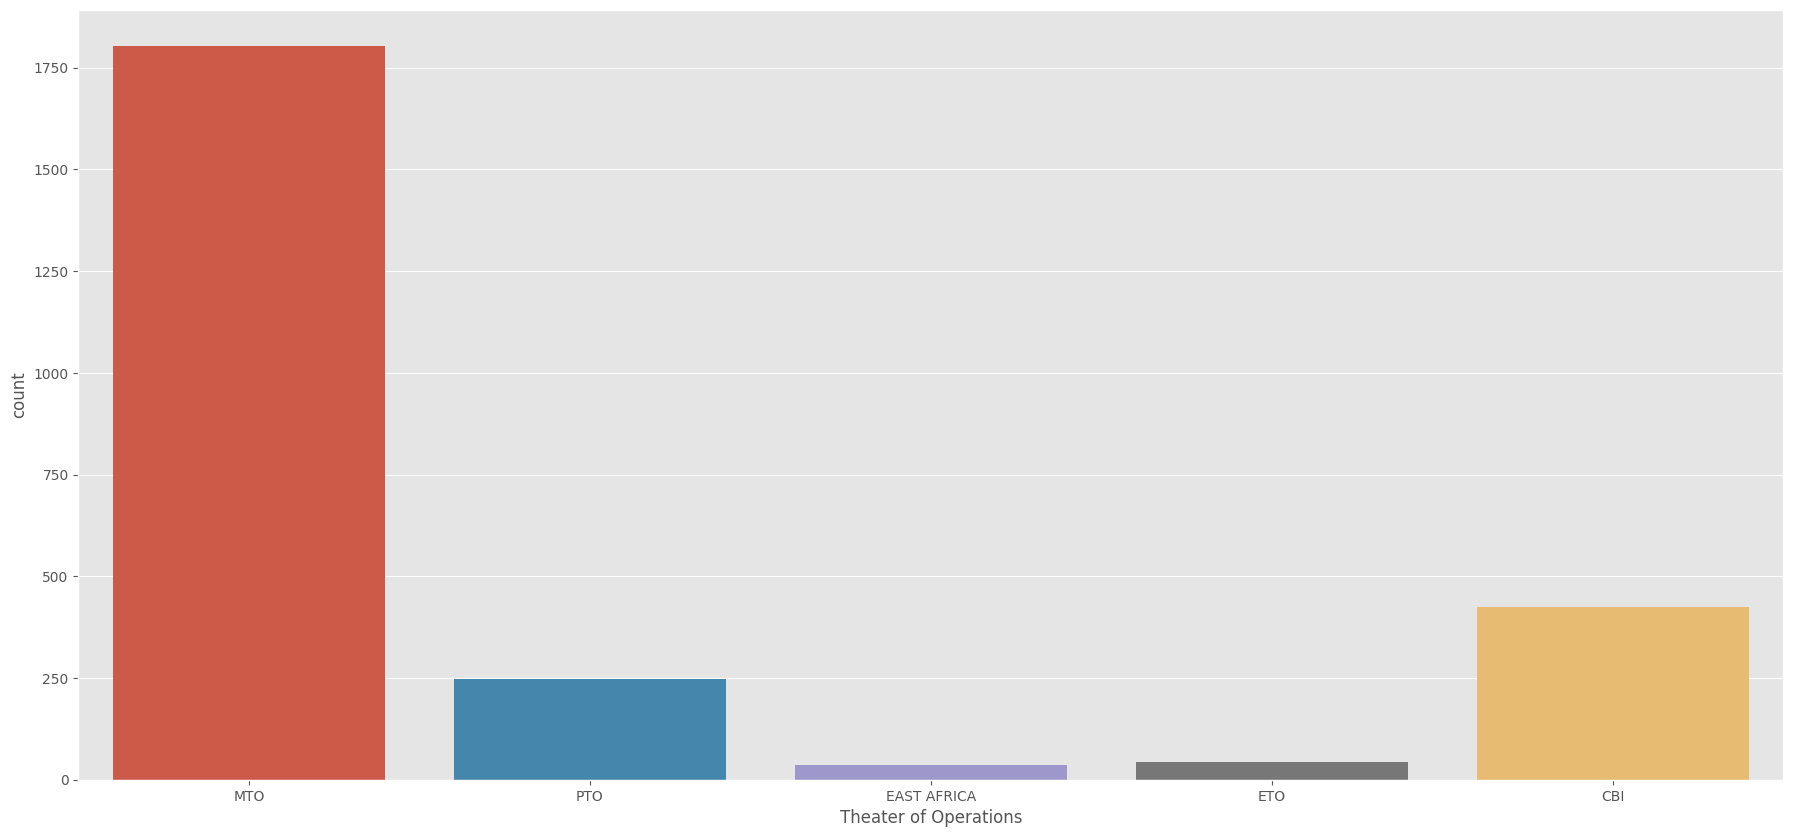

In [14]:
# Theater of Operations
print(aerial_df['Theater of Operations'].value_counts())
plt.figure(figsize = (22, 10))
sns.countplot(data = aerial_df , x = 'Theater of Operations')
plt.show()

In [15]:
# weather station locations

data = [dict(
    type = 'scattergeo',
    lon = weather_station_location_df.Longitude,
    lat = weather_station_location_df.Latitude,
    hoverinfo = 'text',
    text = "Name : " + weather_station_loaction_df.NAME + " Country : " + weather_station_loaction_df['STATE/COUNTRY ID'],
    mode = 'markers',
    marker = dict(
        sizemode = 'area',
        sizeref = 1,
        size = 8,
        line = dict(
            width = 1,
            color = 'white'
        ),
        color = 'blue',
        opacity = 0.7
    )
)]

layout = dict(
    title ='Weather Station Loactions',
    hovermode = 'closest',
    geo = dict(
        showframe = False,
        showland = True,
        showcoastlines = True,
        showcountries = True,
        countrywidth = 1,
        projection = dict(
            type = 'mercator'
        ),
        landcolor = 'rgb(217, 217, 217)',
        subunitwidth = 1,
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)',
        countrycolor = 'rgb(5, 5, 5)'
    )
)

fig = go.Figure(data = data, layout = layout)
iplot(fig)

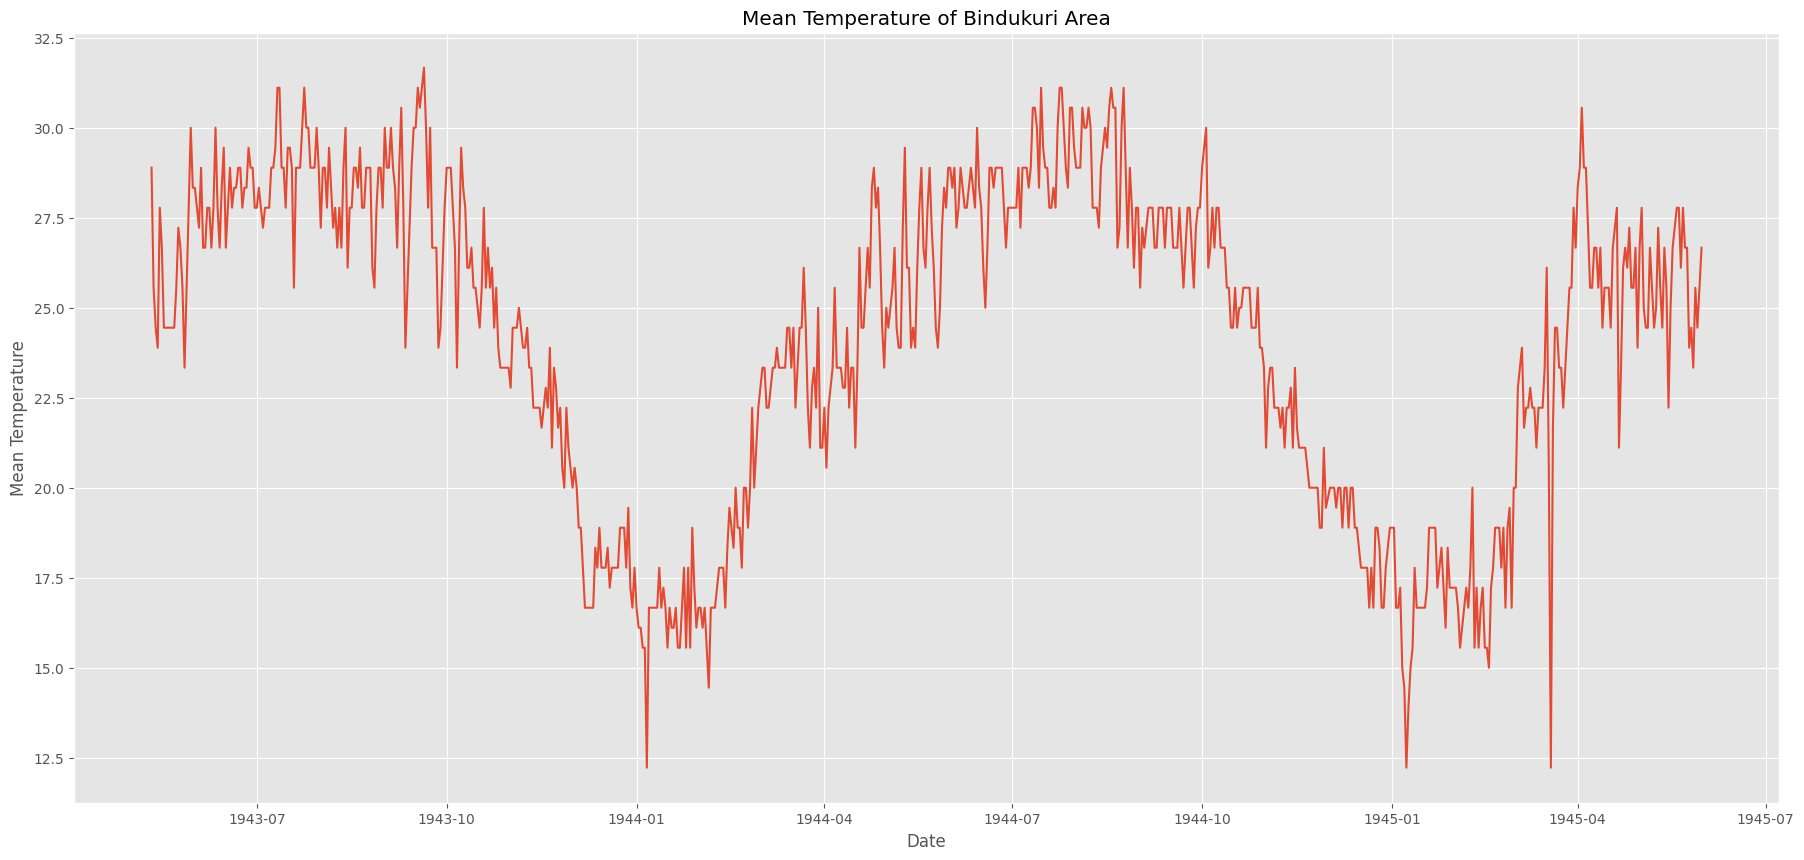

In [16]:
# lets focus on USA vs BURMA
weather_station_id = weather_station_location_df[weather_station_location_df.NAME == 'BINDUKURI'].WBAN
weather_bin = weather_df[weather_df.STA == 32907]
weather_bin['Date'] = pd.to_datetime(weather_bin['Date'])
plt.figure(figsize = (22, 10))
plt.plot(weather_bin.Date, weather_bin.MeanTemp)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.show()

In [17]:
aerial_df = pd.read_csv('/kaggle/input/world-war-ii/operations.csv')
aerial_df['Year'] = [ each.split("/")[2] for each in aerial_df['Mission Date']]
aerial_df['Month'] = [ each.split("/")[0] for each in aerial_df['Mission Date']]
aerial_df = aerial_df[aerial_df['Year'] >= '1943']
aerial_df = aerial_df[aerial_df['Month'] >= "8"]

aerial_df['Mission Date'] = pd.to_datetime(aerial_df['Mission Date'])

attack = 'USA'
target = 'BURMA'
city = 'KATHA'

aerial_war = aerial_df[aerial_df.Country == attack]
aerial_war = aerial_war[aerial_war['Target Country'] == target]
aerial_war = aerial_war[aerial_war['Target City'] == city]

In [18]:
liste = []
aa=  []
for each in aerial_war['Mission Date']:
    dummy = weather_bin[weather_bin.Date == each]
    liste.append(dummy['MeanTemp'].values)

aerial_war['dene'] = liste
for each in aerial_war.dene.values:
    aa.append(each[0])
    
# create a trace
trace = go.Scatter(
    x = weather_bin.Date,
    mode = 'lines',
    y = weather_bin.MeanTemp,
    marker = dict(color = 'rgba(16, 112, 2, 0.8)'),
    name = 'Mean Temperature'
)

trace_1 = go.Scatter(
    x = aerial_war['Mission Date'],
    mode = 'markers',
    y = aa,
    marker = dict(color = 'rgba(16, 0, 200, 1)'),
    name = 'Bombing temperature'
)

layout  = dict(
    title = 'Mean Temperature --- Bombing Dates and Mean Temperature at this Date'
)

data = [trace, trace_1]

fig = dict(data = data, layout = layout)
iplot(fig)

# Prediction with ARIMA

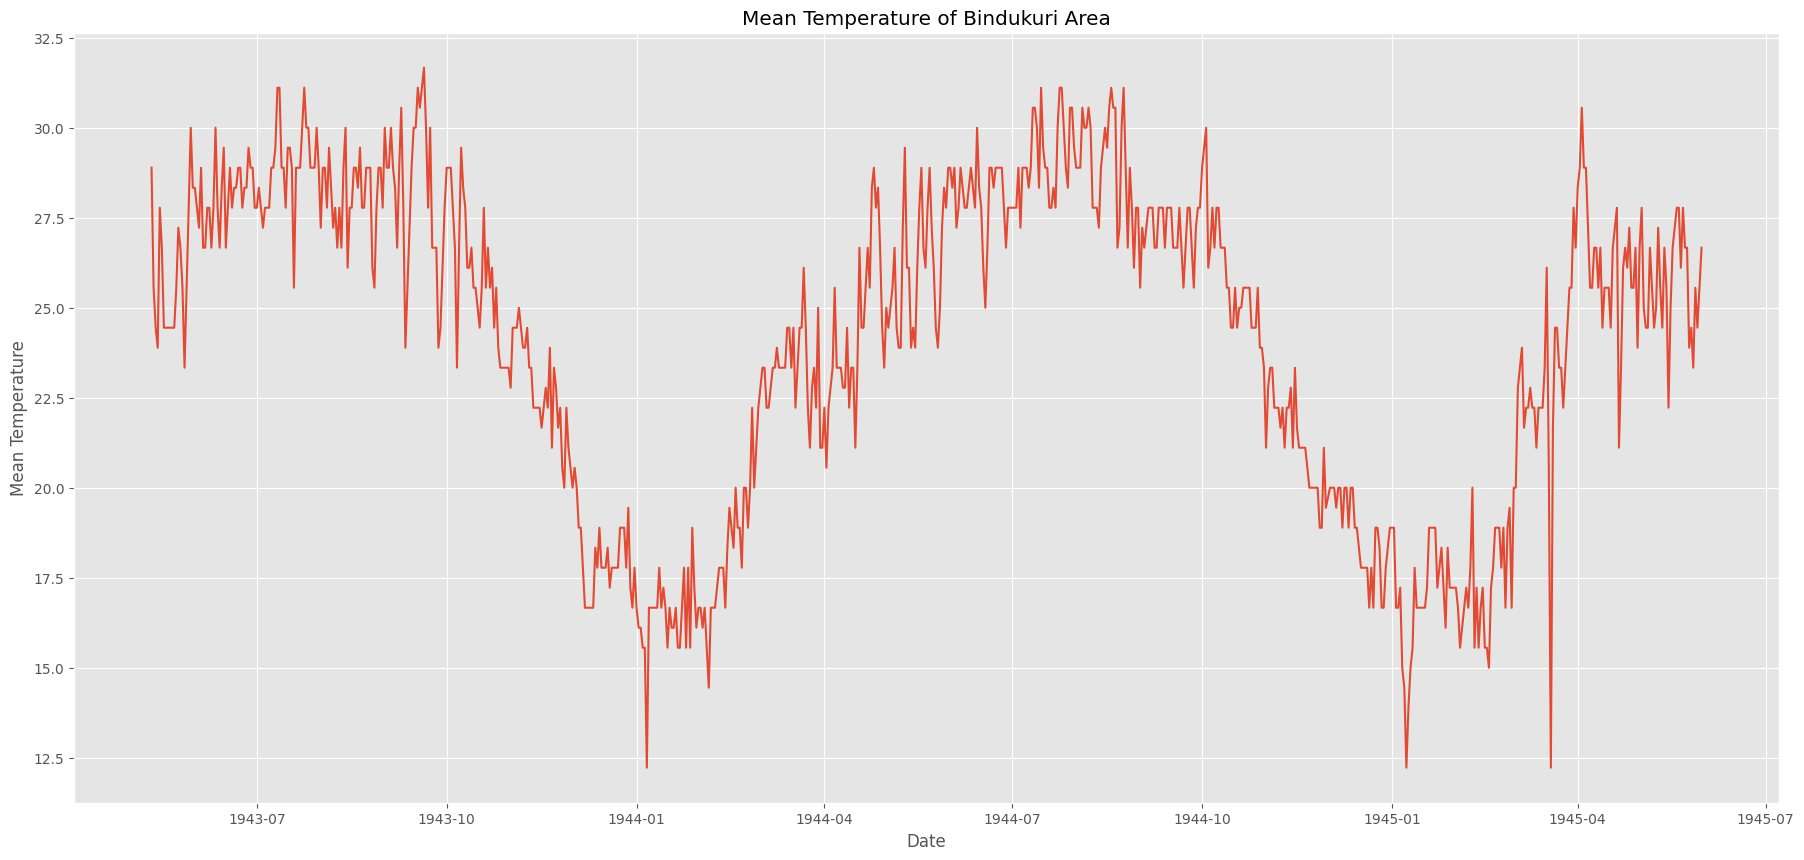

In [19]:
# Mean temperature of Bindikuri area
plt.figure(figsize=(22, 10))
plt.plot(weather_bin.Date, weather_bin.MeanTemp)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

In [20]:
# lets create time series from weather
timeSeries = weather_bin.loc[:,['Date', 'MeanTemp']]
timeSeries.index = timeSeries.Date
ts = timeSeries.drop("Date", axis = 1)


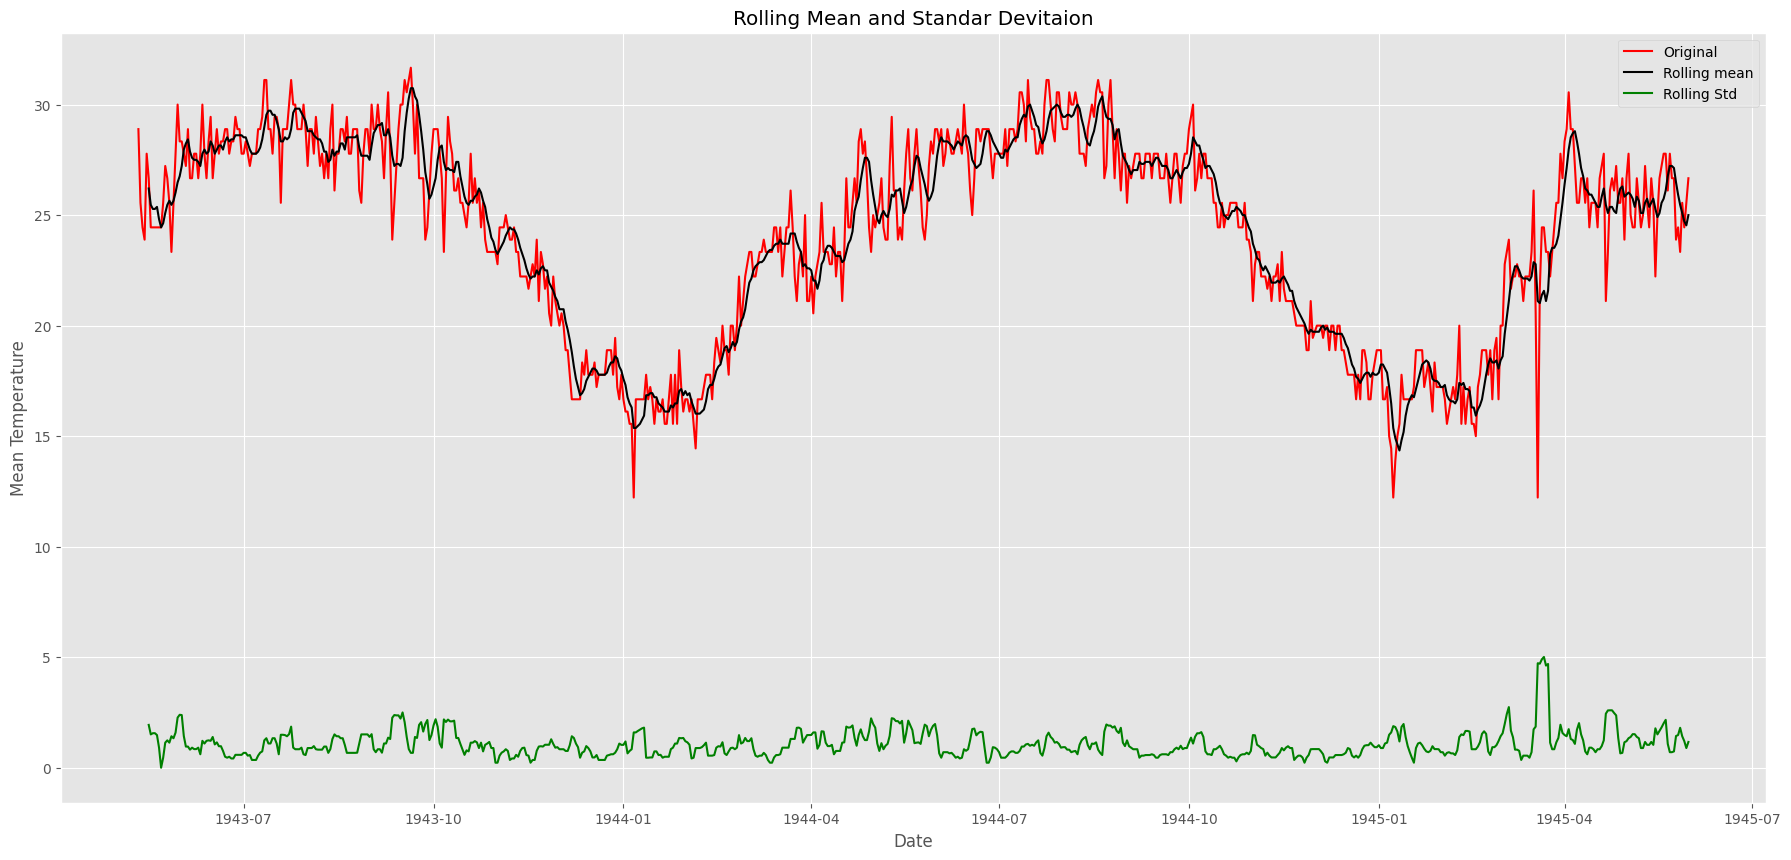

Test Stats :  -1.4095966745887756
p-value :  0.5776668028526357
Critical values :  {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


In [21]:
def check_adfuller(ts):
    result = adfuller(ts, autolag = 'AIC') # Dickey Fuller test, Akaike Information Criterion
    print('Test Stats : ', result[0])
    print('p-value : ', result[1])
    print('Critical values : ', result[4])
    
def check_mean_std(ts):
    rolmean = pd.DataFrame.rolling(ts, window = 6).mean()
    rolstd = pd.DataFrame.rolling(ts, window = 6).std()
    plt.figure(figsize = (22, 10))
    orig = plt.plot(ts, color = 'red', label = 'Original')
    mean = plt.plot(rolmean, color= 'black', label ='Rolling mean')
    std = plt.plot(rolstd, color = 'green', label ='Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title("Rolling Mean and Standar Devitaion")
    plt.legend()
    plt.show()

    
check_mean_std(ts)
check_adfuller(ts.MeanTemp)

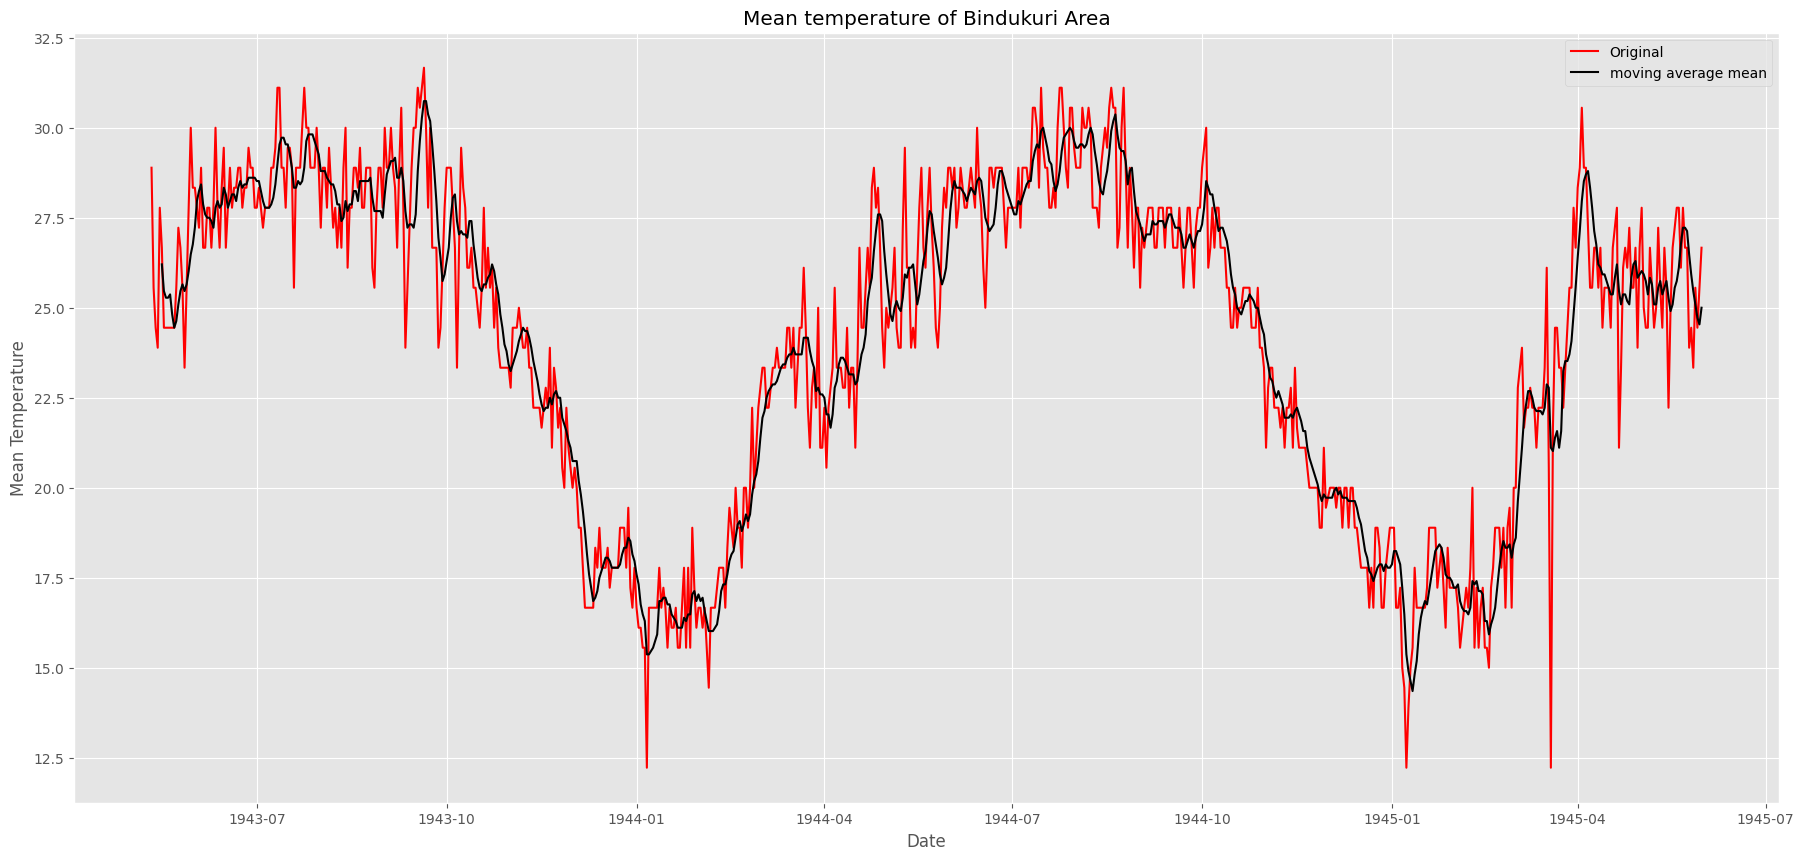

In [22]:
# using moving average to solve trend ( constant mean ) problem
window_size= 6
moving_avg = pd.DataFrame.rolling(ts, window_size).mean()
plt.figure(figsize = (22, 10))
plt.plot(ts, color  = 'red', label = 'Original')
plt.plot(moving_avg, color = 'black', label = 'moving average mean')
plt.title("Mean temperature of Bindukuri Area")
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

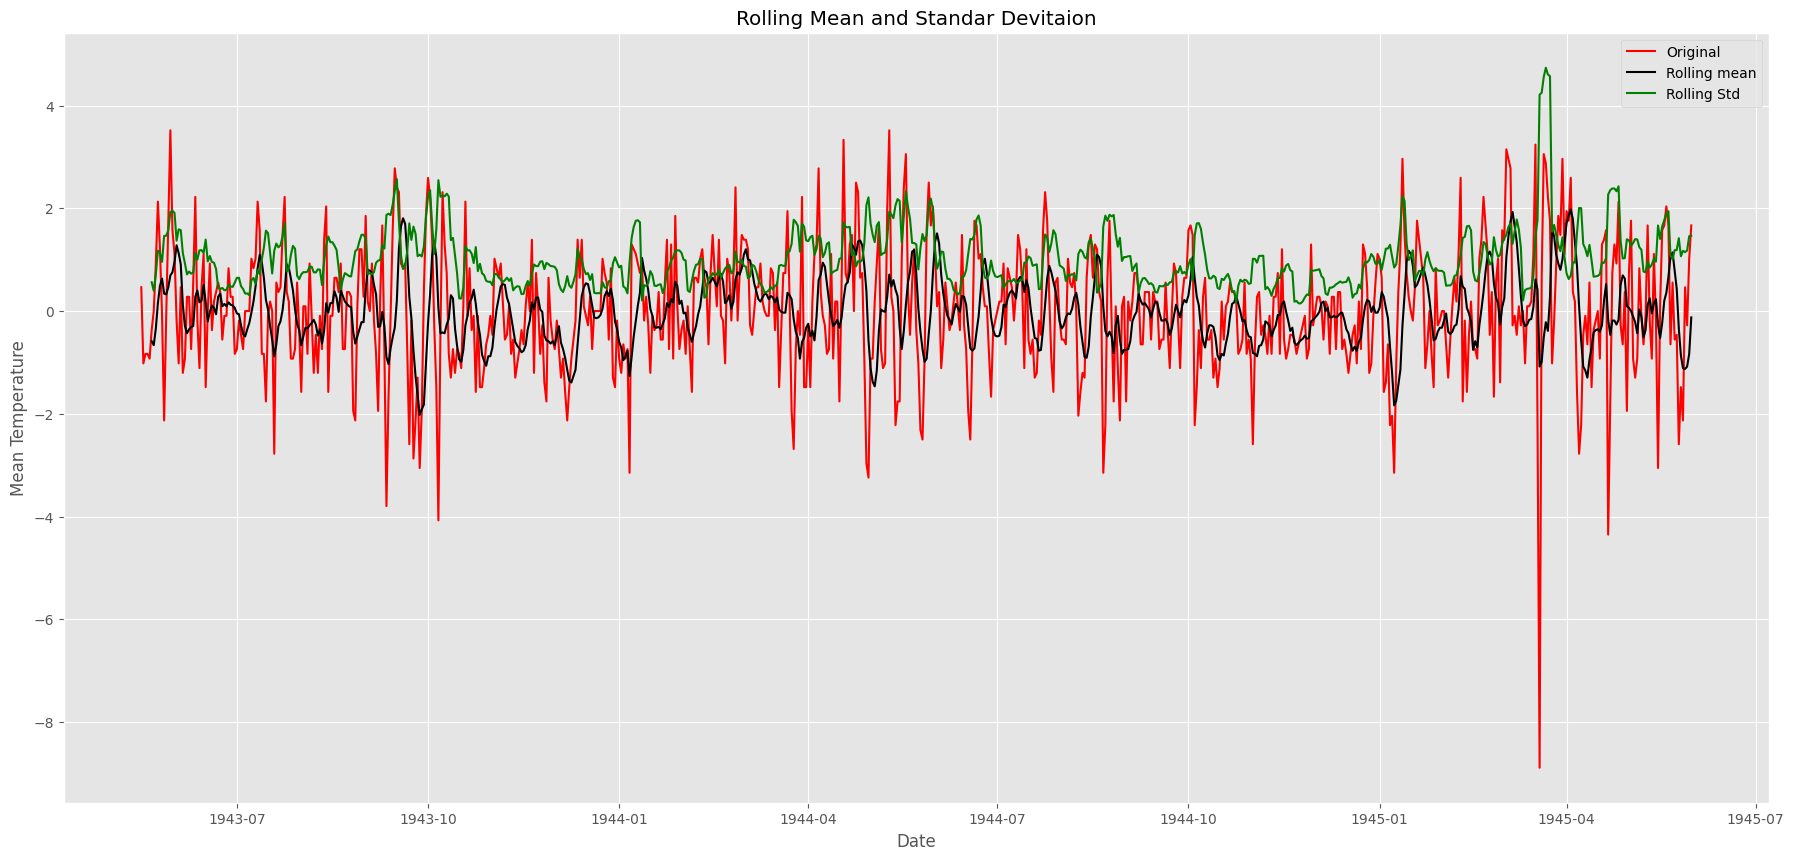

Test Stats :  -11.1385143351385
p-value :  3.150868563164087e-20
Critical values :  {'1%': -3.4392539652094154, '5%': -2.86546960465041, '10%': -2.5688625527782327}


In [23]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.dropna(inplace = True)

check_mean_std(ts_moving_avg_diff)
check_adfuller(ts_moving_avg_diff.MeanTemp)

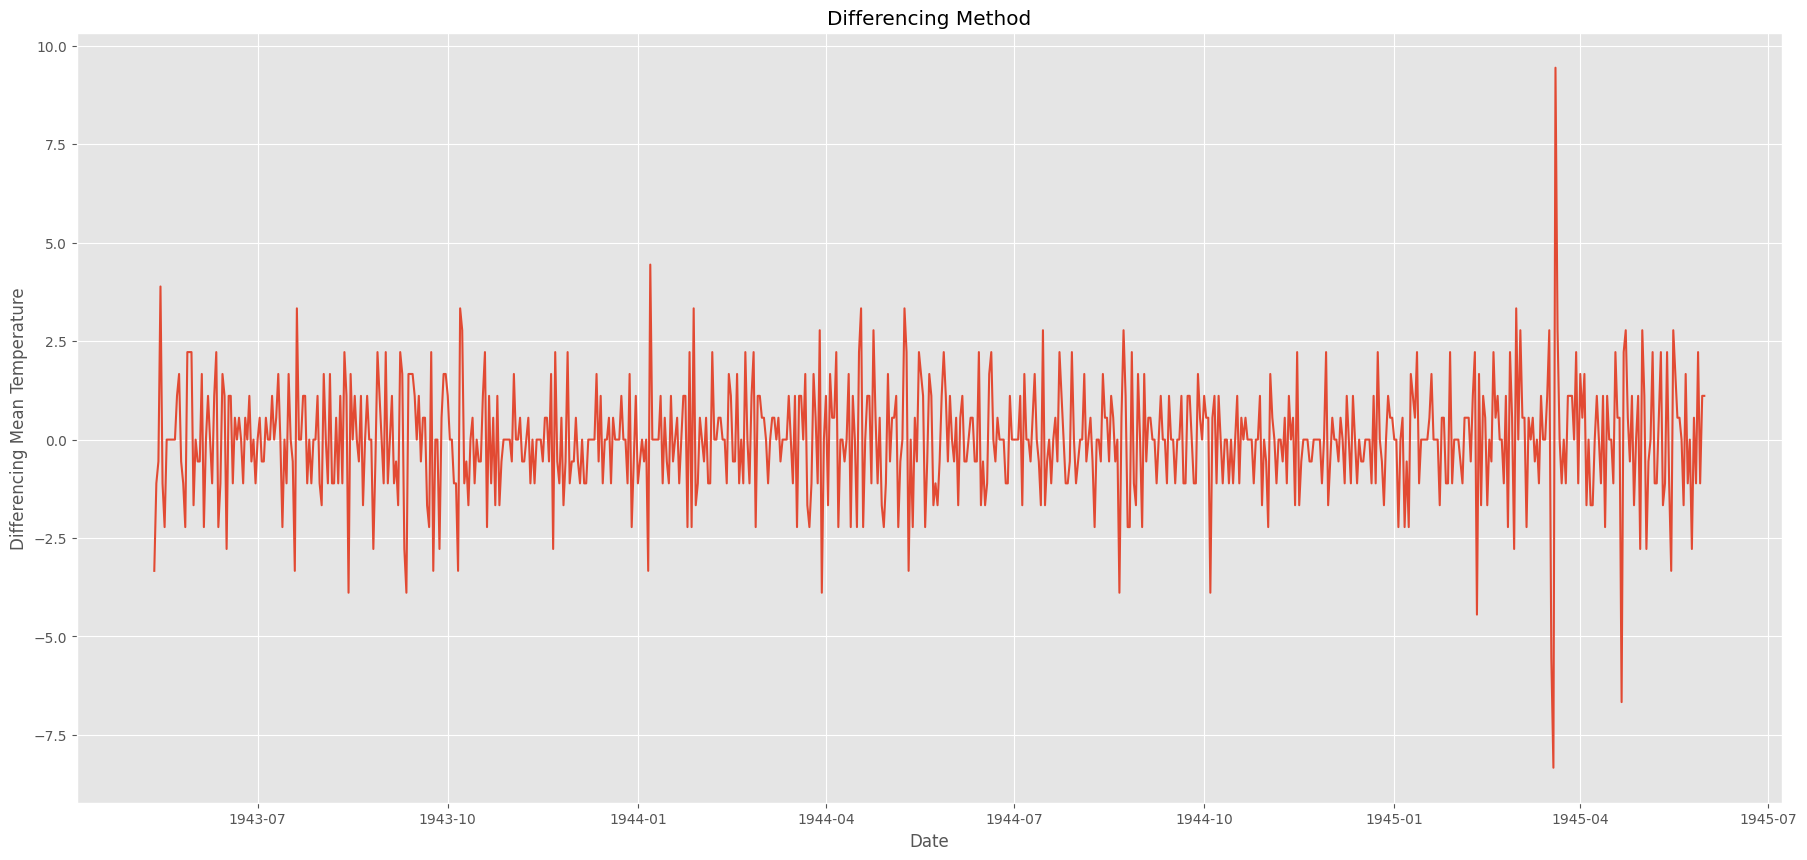

In [24]:
# differencing method
ts_diff = ts - ts.shift()
plt.figure(figsize = (22, 10))
plt.plot(ts_diff)
plt.title('Differencing Method')
plt.xlabel('Date')
plt.ylabel('Differencing Mean Temperature')
plt.show()

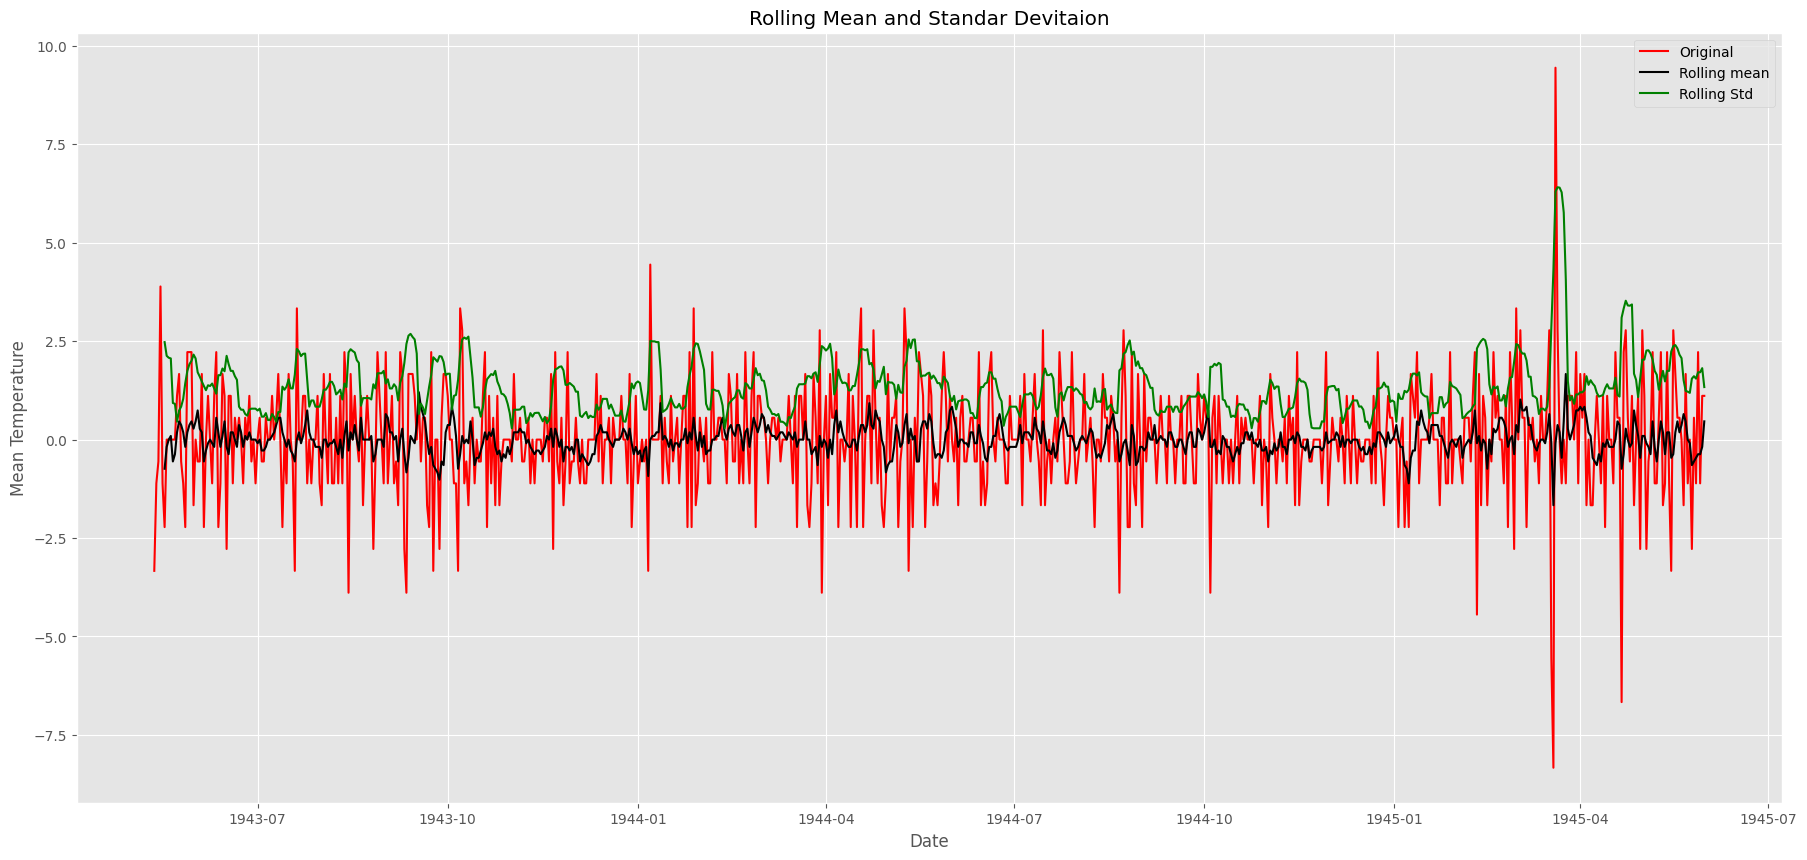

Test Stats :  -11.678955575105386
p-value :  1.7602075693558073e-21
Critical values :  {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


In [25]:
ts_diff.dropna(inplace = True)
check_mean_std(ts_diff)
check_adfuller(ts_diff.MeanTemp)

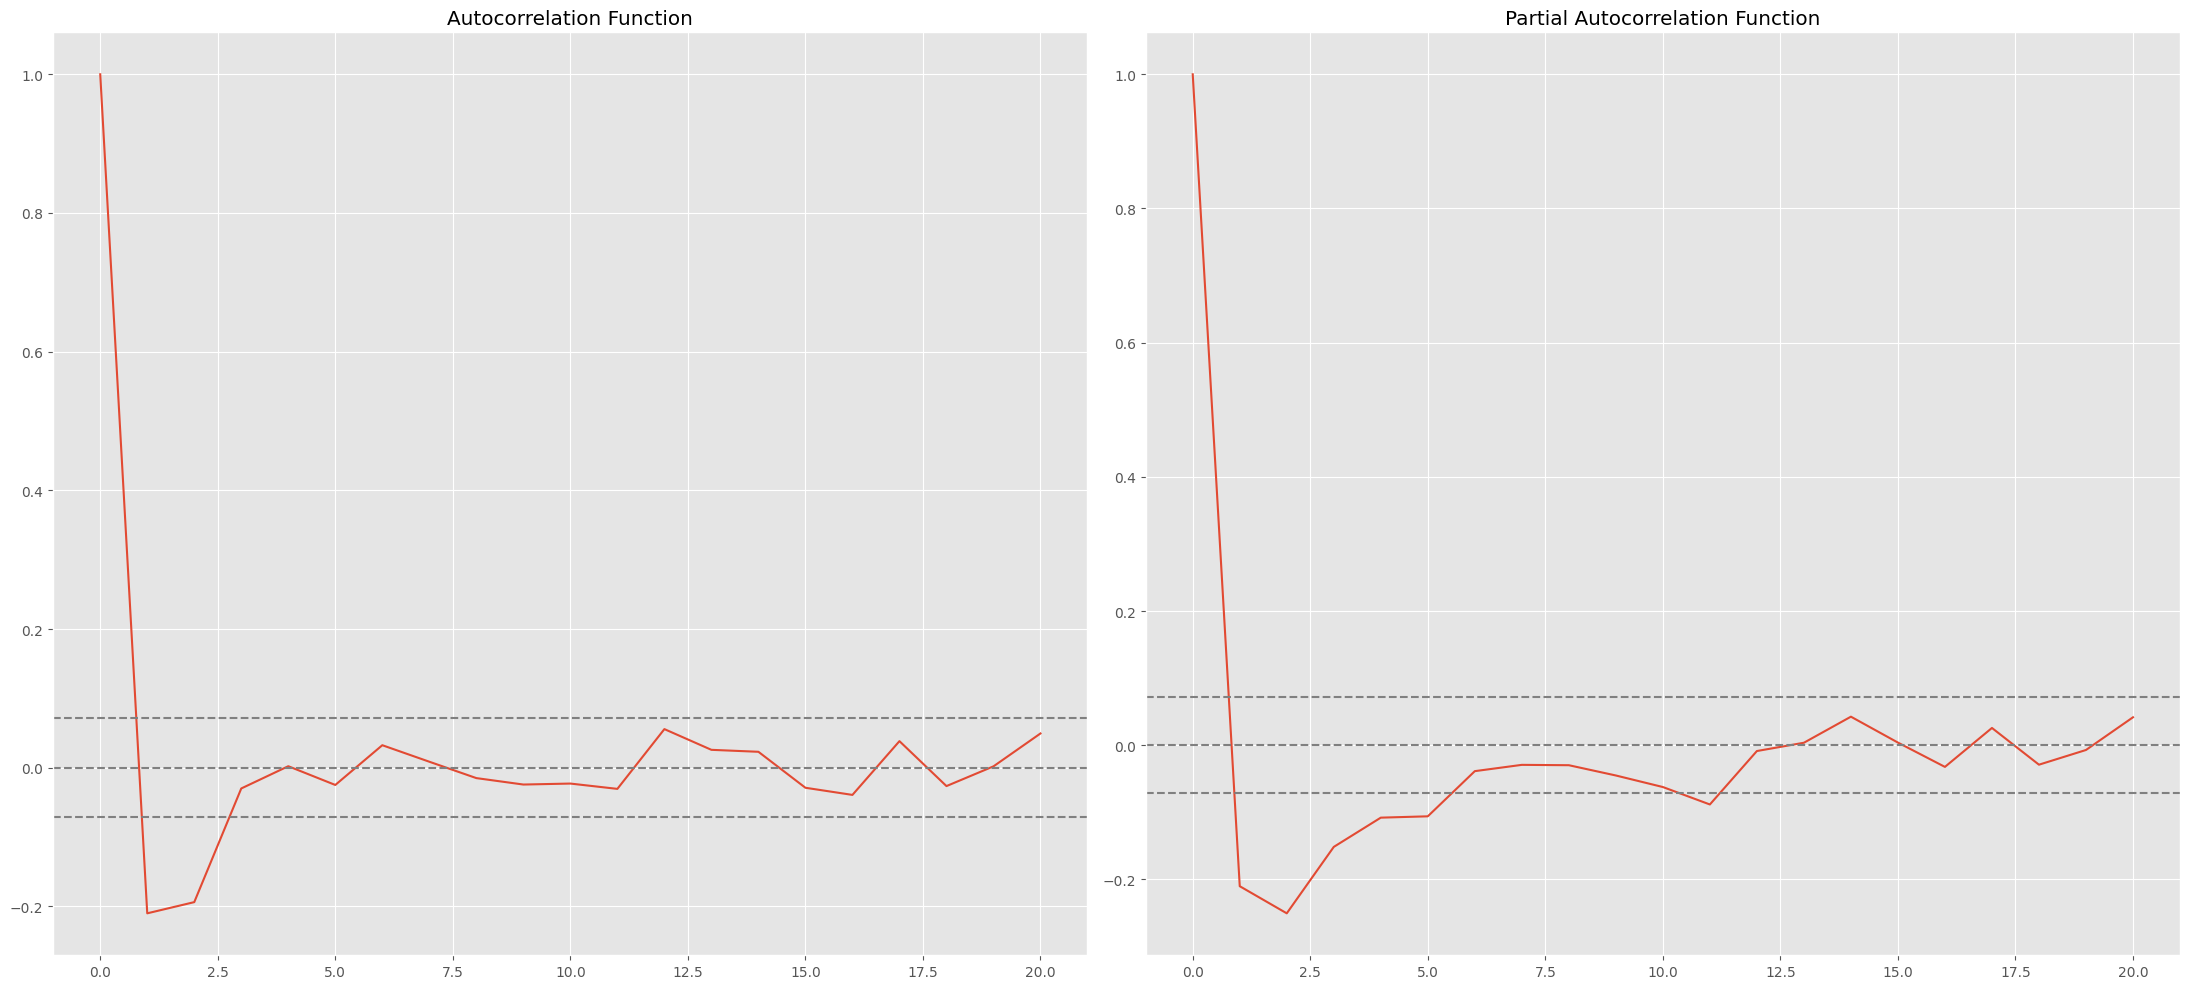

In [26]:
# ACF and PACF
lag_acf = acf(ts_diff,nlags = 20)
lag_pacf = pacf(ts_diff, nlags = 20, method = 'ols')


# ACF
plt.figure(figsize = (22, 10))

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color ='gray')
plt.axhline(y = -1.96 / np.sqrt(len(ts_diff)), linestyle = '--', color ='gray')
plt.axhline(y = 1.96 / np.sqrt(len(ts_diff)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')


# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color ='gray')
plt.axhline(y = -1.96 / np.sqrt(len(ts_diff)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/ np.sqrt(len(ts_diff)), linestyle = '--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

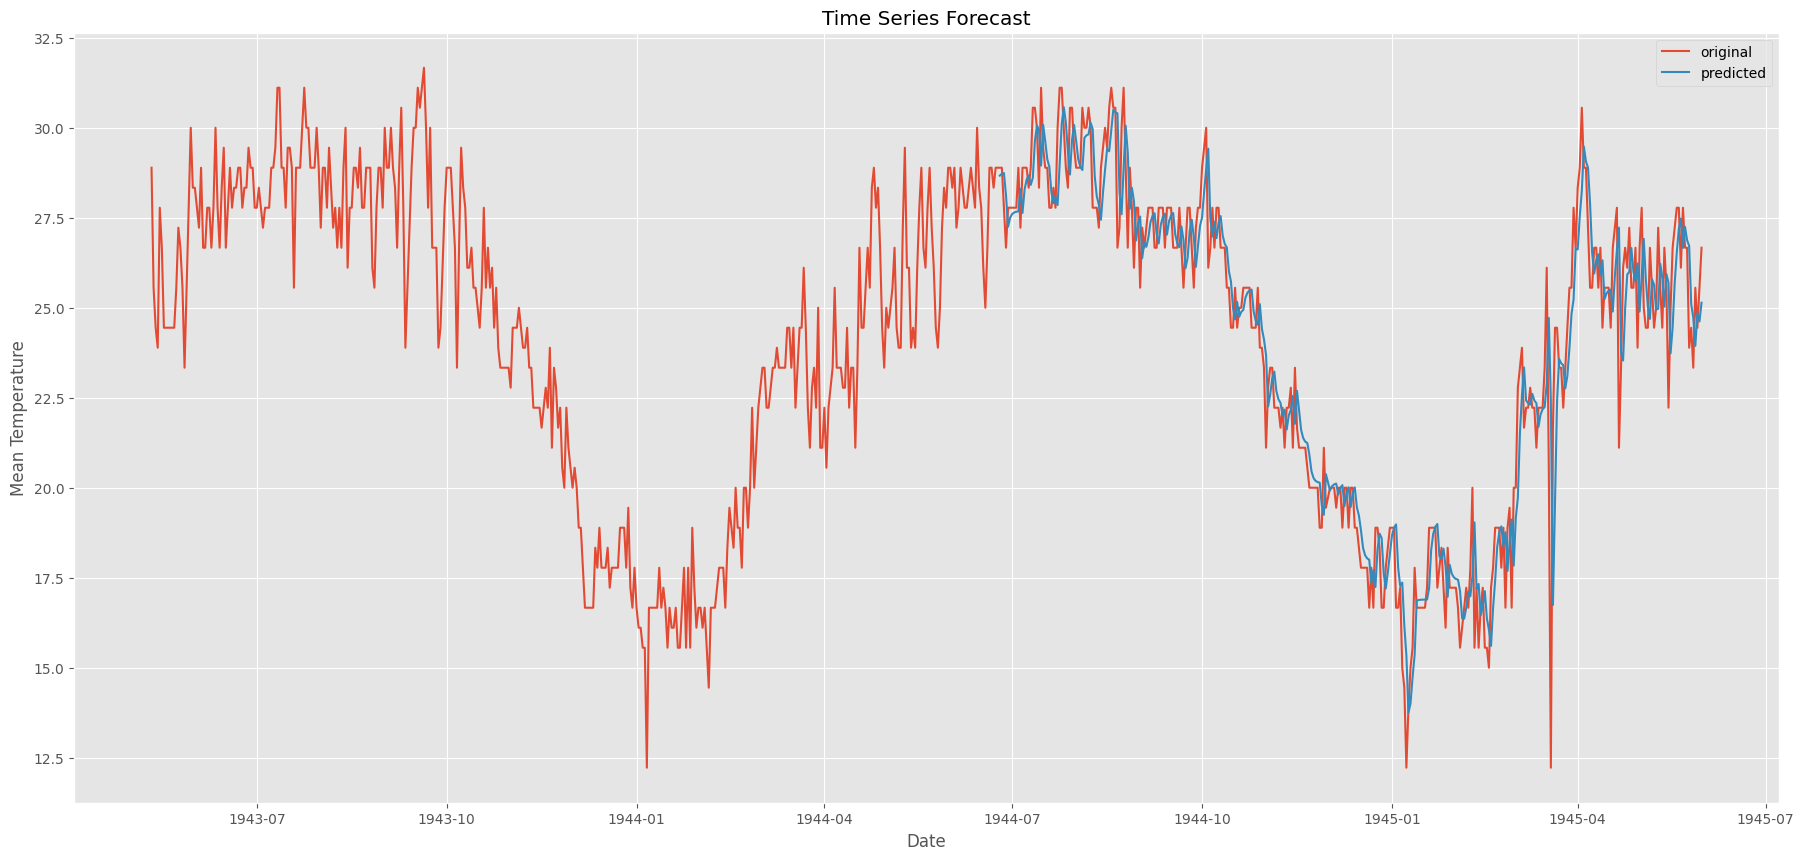

In [27]:
model = ARIMA(ts, order=(1, 0, 1))
model_fit = model.fit()

forecast = model_fit.predict(start = datetime.datetime(1944, 6, 25), end = datetime.datetime(1945, 5, 31))

plt.figure(figsize=(22, 10))
plt.plot(weather_bin.Date, weather_bin.MeanTemp, label = "original")
plt.plot(forecast, label = 'predicted')
plt.title('Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

error :  1.8625810278777963


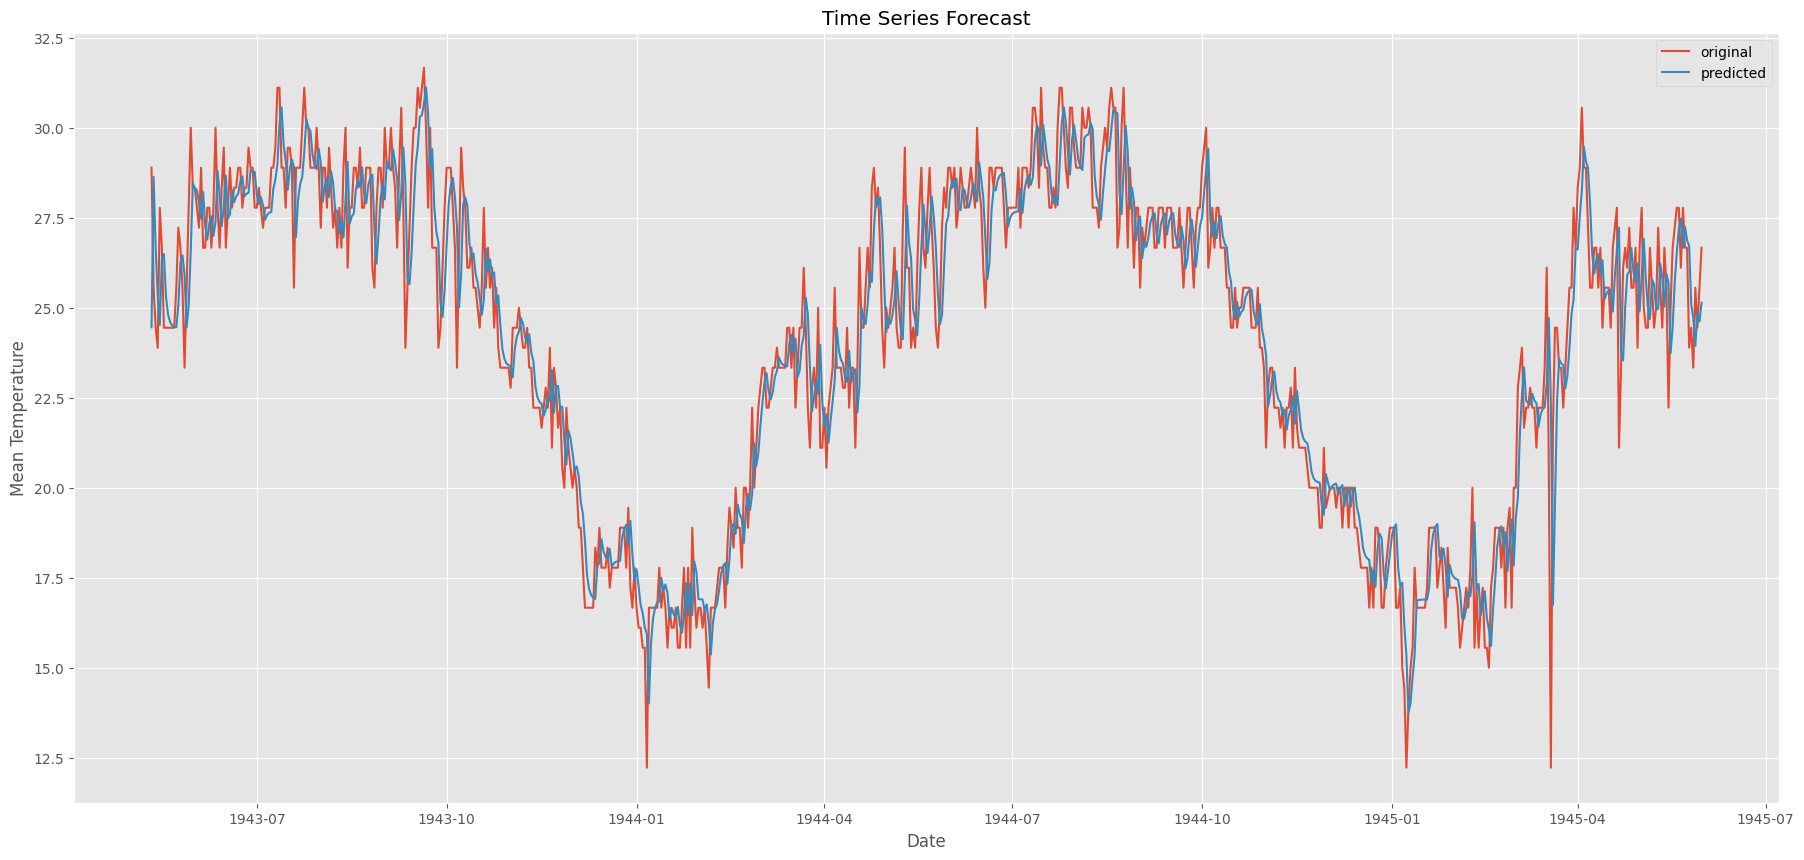

In [28]:
model_2 = ARIMA(ts, order = (1, 0, 1))
model_fit_2 = model_2.fit()
forecast_2 = model_fit_2.predict()
error = mean_squared_error(ts, forecast_2)
print("error : ", error)

#visualization
plt.figure(figsize=(22, 10))
plt.plot(weather_bin.Date, weather_bin.MeanTemp, label = 'original')
plt.plot(forecast_2, label = 'predicted')
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()